In [2]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np

import argparse as ap

def recompute_hard_labels(soft_labels):
    """optionally, infer hard labels from the soft labels provided"""
    hard_labels = [] 
    prev_end = -1
    for start, end in (
        (lbl['start'], lbl['end']) 
        for lbl in sorted(soft_labels, key=lambda span: (span['start'], span['end']))
        if lbl['prob'] > 0.5
    ):
        if start == prev_end:
            hard_labels[-1][-1] = end
        else:
            hard_labels.append([start, end])
        prev_end = end
    return hard_labels


def infer_soft_labels(hard_labels):
    """reformat hard labels into soft labels with prob 1"""
    return [
        {
            'start': start,
            'end': end,
            'prob': 1.0,
        }
        for start, end in hard_labels
    ]

def load_jsonl_file_to_records(filename, is_ref=True):
    """read data from a JSONL file and format that as a `pandas.DataFrame`.
    Performs minor format checks (ensures that some labels are present,
    optionally compute missing labels on the fly)."""
    df = pd.read_json(filename, lines=True)
    if not is_ref:
        assert ('hard_labels' in df.columns) or ('soft_labels' in df.columns), \
            f'File {filename} contains no predicted label!'
        if 'hard_labels' not in df.columns:
            df['hard_labels'] = df.soft_labels.apply(recompute_hard_labels)
        elif 'soft_labels' not in df.columns:
            df['soft_labels'] = df.hard_labels.apply(infer_soft_labels)
    # adding an extra column for convenience
    columns = ['id', 'soft_labels', 'hard_labels']
    if is_ref:
        df['text_len'] = df.model_output_text.apply(len)
        columns += ['text_len']
    df = df[columns]
    return df.sort_values('id').to_dict(orient='records')

In [3]:
def calculate_soft_labels(words, hallucination_scores):
    soft_labels = []
    
    # Initialize the starting position of the first word
    start_position = 0

    for word, score in zip(words, hallucination_scores):
        word_length = len(word)
        
        # Calculate the ending position
        end_position = start_position + word_length
        
        # Append the soft label entry
        soft_labels.append({
            "start": start_position,
            "prob": score,
            "end": end_position
        })
        
        # Update the starting position for the next word (accounting for space)
        start_position = end_position  # Add 2 for the space between words

    return soft_labels

# Example usage
data = {
    "words evaluated": [" ", "No,", "Albero", "Foulois", "was", "not", "in", "any", "of", "the", "FIFA", "World", "Cup", "finals.\n"],
    "hallucination_scores_evaluated": [0, 1.0, 0.06837508948018978, 0.9810742402775567, 0.5219719747190859, 0.8440420620456921, 0.039483340157654756, 0.7283849860862854, 0.0, 0.12374613816374336, 0.9193932406560029, 0.0, 0.0, 0.0]
}

soft_labels = calculate_soft_labels(data["words evaluated"], data["hallucination_scores_evaluated"])

# Output the result
print(soft_labels)

hard_labels = recompute_hard_labels(soft_labels)
print(hard_labels)


[{'start': 0, 'prob': 0, 'end': 1}, {'start': 1, 'prob': 1.0, 'end': 4}, {'start': 4, 'prob': 0.06837508948018978, 'end': 10}, {'start': 10, 'prob': 0.9810742402775567, 'end': 17}, {'start': 17, 'prob': 0.5219719747190859, 'end': 20}, {'start': 20, 'prob': 0.8440420620456921, 'end': 23}, {'start': 23, 'prob': 0.039483340157654756, 'end': 25}, {'start': 25, 'prob': 0.7283849860862854, 'end': 28}, {'start': 28, 'prob': 0.0, 'end': 30}, {'start': 30, 'prob': 0.12374613816374336, 'end': 33}, {'start': 33, 'prob': 0.9193932406560029, 'end': 37}, {'start': 37, 'prob': 0.0, 'end': 42}, {'start': 42, 'prob': 0.0, 'end': 45}, {'start': 45, 'prob': 0.0, 'end': 53}]
[[1, 4], [10, 23], [25, 28], [33, 37]]


# Generation of soft and hard labels

In [7]:
import json 
import os

data_dir = "data/test"
output_path = os.path.join(data_dir, "results_full.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        processed_data = [json.loads(line) for line in f]

In [12]:
len(processed_data[1]['results']), len(processed_data[1]['words_evaluated'])

(7, 7)

In [3]:
import json 
import os

data_dir = "data/test"
output_path = os.path.join(data_dir, "results_mult.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        processed_data = [json.loads(line) for line in f]
result_path = os.path.join(data_dir, "final_results.jsonl")

for entry in processed_data: 
    try:
        words_evaluated = entry['words evaluated']
        hallucination_scores_evaluated = entry['hallucination_scores_evaluated']
    except:
        words_evaluated = entry['hallucination_scores_evaluated'][0]
        hallucination_scores_evaluated = entry['hallucination_scores_evaluated'][1]
    
    # if the first element of the words evaluated is "", then remove it and the corresponding hallucination score
    if words_evaluated[0] == "":
        words_evaluated[0] = " "
        hallucination_scores_evaluated[0] = 0
    
    soft_labels = calculate_soft_labels(words_evaluated, hallucination_scores_evaluated)
    hard_labels = recompute_hard_labels(soft_labels)

    # save the hard labels to the processed data
    entry['hard_labels'] = hard_labels
    entry['soft_labels'] = soft_labels

    # save the processed data to the new file
    with open(result_path, "w") as f:
        for entry in processed_data:
            f.write(json.dumps(entry) + "\n")
        
    assert len(words_evaluated) == len(hallucination_scores_evaluated)
    

# MNLI on full sentence dataset

In [1]:
import os
import json

data_dir = "data/val"
output_path = os.path.join(data_dir, "results_full.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        processed_data = [json.loads(line) for line in f]

In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

def get_mnli_probs(sentence_1, sentence_2, model, tokenizer, device = "cpu"):
    inputs = tokenizer(sentence_1, sentence_2, return_tensors="pt").to(device)
    outputs = model(**inputs)
    predicted_class_prob = outputs.logits.softmax(dim=1)
    return predicted_class_prob

# use device 1 



device = "cpu"

mnli_model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/nli-deberta-v3-large").to(device)
mnli_tokenizer = AutoTokenizer.from_pretrained("cross-encoder/nli-deberta-v3-large")

In [7]:
from tqdm import tqdm

for sample in tqdm(processed_data):
    gold_sentence = sample['model_output_text']
    for i, results in enumerate(sample['results']):
        word_to_replace = sample['words_evaluated'][i]
        for result in results: 
            word = result['full_word']
            output_sentence = gold_sentence.replace(word_to_replace, word)
            prob = get_mnli_probs(gold_sentence, output_sentence, mnli_model, mnli_tokenizer, device).tolist()
            result['sentence_mnli_prob'] = prob
    torch.cuda.empty_cache()



  4%|▍         | 2/49 [00:34<13:30, 17.25s/it]


KeyboardInterrupt: 

In [ ]:
# save the processed data to the new file
result_path = os.path.join(data_dir, "results_full_sentence.jsonl")
with open(result_path, "w") as f:
    for entry in processed_data:
        f.write(json.dumps(entry) + "\n")

In [85]:
sample['results'][5]

[{'token_id': 6623,
  'token_prob': 0.9362645149230957,
  'full_word': 'gold',
  'full_prob': 1.0,
  'mnli_probs': [[0.05534587427973747,
    0.891874372959137,
    0.05277978256344795]],
  'sentence_mnli_prob': [[0.9993163347244263,
    0.0001330594823230058,
    0.0005505845183506608]]}]

# Treshold evaluation on val dataset

In [38]:
import numpy as np

def convert_probs_to_array(probs, dim):
    array = np.zeros(dim)
    
    for prob in probs:
        start = prob['start']
        end = prob['end']
        prob = prob['prob']
        
        array[start:end] = prob
    
    return array

In [10]:
import os
import json

data_dir = "data/val"
output_path = os.path.join(data_dir, "results_full.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        processed_data = [json.loads(line) for line in f]

In [12]:
processed_data[0].keys()

dict_keys(['id', 'lang', 'model_input', 'model_output_text', 'model_id', 'soft_labels', 'hard_labels', 'model_output_logits', 'model_output_tokens', 'words_evaluated', 'results'])

In [45]:
gold = convert_probs_to_array(processed_data[0]['soft_labels'], len(processed_data[0]['model_output_text']))
gold

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.2, 0.3,
       0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.2, 0.2, 0.2, 0.2, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0. ])

In [28]:
for entry in processed_data:
    assert len(entry['words_evaluated']) == len(entry['results'])

res = processed_data[0]['results']
res

[[{'token_id': 358,
   'token_prob': 0.15003474056720734,
   'full_word': "I'm",
   'full_prob': 0.960303008556366,
   'mnli_probs': [[0.9515063166618347,
     0.021333100274205208,
     0.027160659432411194]]},
  {'token_id': 83937,
   'token_prob': 0.10151859372854233,
   'full_word': 'Petra',
   'full_prob': 1.0,
   'mnli_probs': [[0.0025015766732394695,
     0.9782932996749878,
     0.019205152988433838]]},
  {'token_id': 1634,
   'token_prob': 0.08221225440502167,
   'full_word': 'As',
   'full_prob': 1.0,
   'mnli_probs': [[0.8339728116989136,
     0.05106065049767494,
     0.11496655642986298]]},
  {'token_id': 320,
   'token_prob': 0.033216752111911774,
   'full_word': '(If',
   'full_prob': 0.07571055740118027,
   'mnli_probs': [[0.6524307727813721,
     0.11615093797445297,
     0.23141822218894958]]},
  {'token_id': 220,
   'token_prob': 0.02430189587175846,
   'full_word': '',
   'full_prob': 1.0,
   'mnli_probs': [[0.11921315640211105,
     0.018700353801250458,
     0.862

In [29]:
'''
"id2label": {
    "0": "contradiction",
    "1": "entailment",
    "2": "neutral"
  },
'''

'\n"id2label": {\n    "0": "contradiction",\n    "1": "entailment",\n    "2": "neutral"\n  },\n'

In [36]:
soft_labels_per_word = []
for word in res: 
    print(word)
    p_i = [prob['token_prob'] for prob in word]
    print(p_i)
    p_plus = [prob['mnli_probs'][0][1] + prob['mnli_probs'][0][2] for prob in word]
    print(p_plus)
    p_i = np.array(p_i)
    p_plus = np.array(p_plus)
    hallucination_score = 1 - (sum(p_i * p_plus) / sum(p_i))
    print(hallucination_score)
    soft_labels_per_word.append(hallucination_score)

soft_labels = calculate_soft_labels(processed_data[0]['words_evaluated'], soft_labels_per_word)

[{'token_id': 358, 'token_prob': 0.15003474056720734, 'full_word': "I'm", 'full_prob': 0.960303008556366, 'mnli_probs': [[0.9515063166618347, 0.021333100274205208, 0.027160659432411194]]}, {'token_id': 83937, 'token_prob': 0.10151859372854233, 'full_word': 'Petra', 'full_prob': 1.0, 'mnli_probs': [[0.0025015766732394695, 0.9782932996749878, 0.019205152988433838]]}, {'token_id': 1634, 'token_prob': 0.08221225440502167, 'full_word': 'As', 'full_prob': 1.0, 'mnli_probs': [[0.8339728116989136, 0.05106065049767494, 0.11496655642986298]]}, {'token_id': 320, 'token_prob': 0.033216752111911774, 'full_word': '(If', 'full_prob': 0.07571055740118027, 'mnli_probs': [[0.6524307727813721, 0.11615093797445297, 0.23141822218894958]]}, {'token_id': 220, 'token_prob': 0.02430189587175846, 'full_word': '', 'full_prob': 1.0, 'mnli_probs': [[0.11921315640211105, 0.018700353801250458, 0.8620864152908325]]}, {'token_id': 576, 'token_prob': 0.023008573800325394, 'full_word': 'The', 'full_prob': 1.0, 'mnli_pro

In [42]:
res_obtained = convert_probs_to_array(soft_labels, len(processed_data[0]['model_output_text']))

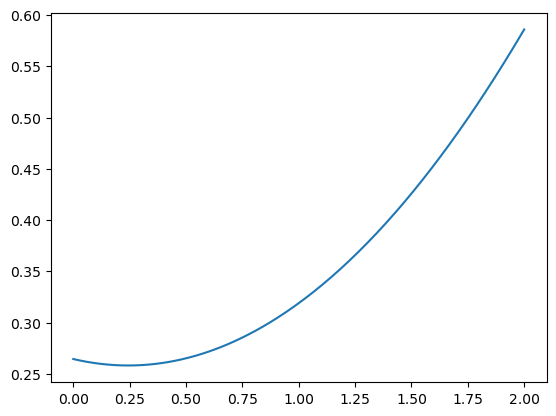

In [47]:
# evaluate mse between two arrays
from sklearn.metrics import mean_squared_error

mean_squared_error(res_obtained, gold)

# optimization problem to find a multiplicative factor that minimize the mse

thetas = np.linspace(0, 2, 200)
mses = []
for theta in thetas:
    mse = mean_squared_error(res_obtained * theta, gold)
    mses.append(mse)

import matplotlib.pyplot as plt

plt.plot(thetas, mses)
plt.show()

In [66]:
target = []
output = []

for entry in processed_data:
    res = entry['results']
    soft_labels_per_word = []
    for word in res: 
        p_i = [prob['token_prob'] for prob in word]
        p_plus = [prob['mnli_probs'][0][1] + prob['mnli_probs'][0][2] for prob in word]
        #p_plus = [prob['mnli_probs'][0][1] for prob in word]
        p_i = np.array(p_i)
        p_plus = np.array(p_plus)
        hallucination_score = 1 - (sum(p_i * p_plus) / sum(p_i))
        soft_labels_per_word.append(hallucination_score)

    soft_labels = calculate_soft_labels(entry['words_evaluated'], soft_labels_per_word)
    res_obtained = convert_probs_to_array(soft_labels, len(entry['model_output_text']))
    gold = convert_probs_to_array(entry['soft_labels'], len(entry['model_output_text']))
    target.append(gold)
    output.append(res_obtained)

print(len(target), len(output))   

49 49


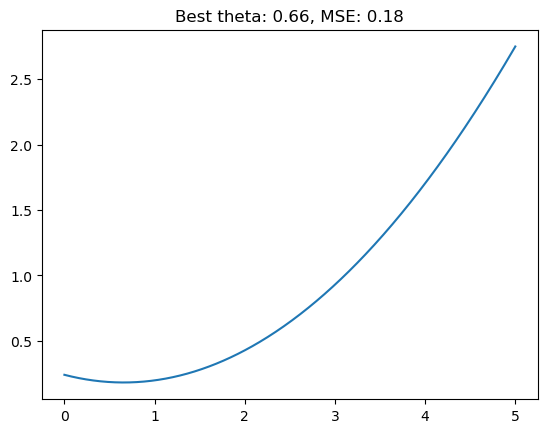

In [67]:
# make an optimization problem to find the best theta that minimize the mse
thetas = np.linspace(0, 5, 500)
mses = []
for theta in thetas:
    temp = []
    for i in range(len(output)):
        mse = mean_squared_error(output[i] * theta, target[i])
        temp.append(mse)
    mses.append(np.mean(temp))

plt.plot(thetas, mses)

# as title, show the best theta and the mse (2 decimal places)
best_theta = thetas[np.argmin(mses)]
best_mse = np.min(mses)
plt.title(f"Best theta: {best_theta:.2f}, MSE: {best_mse:.2f}")
plt.show()

In [59]:
# print theta at 1 
mses[100]

0.19777302731603516

In [72]:
from transformers import pipeline

# Load a small LLM
llm = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.1")

# Define sentences
sentence1 = "He won a gold medal."
sentence2 = "He won a silver medal."

# Craft a minimal prompt
prompt = f"""
Determine if the second sentence logically follows from the first.
Answer only with "ENTAILMENT" or "NOT ENTAILMENT".

Sentence 1: "{sentence1}"
Sentence 2: "{sentence2}"

Answer:
"""

# Generate response
response = llm(prompt, max_length=10, do_sample=False)
label = response[0]["generated_text"].strip()

print(label)

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1.
401 Client Error. (Request ID: Root=1-679b5f22-516ff60e60233a7237efa3f3;d8bb0646-3070-48a3-8f23-a6f38a97243a)

Cannot access gated repo for url https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1/resolve/main/config.json.
Access to model mistralai/Mistral-7B-Instruct-v0.1 is restricted. You must have access to it and be authenticated to access it. Please log in.